<a href="https://colab.research.google.com/github/sunnyshahabuddin/30-Days-of-Code/blob/master/Behavioral_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [23]:
!ls Track

ls: cannot access 'Track': No such file or directory


In [24]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #to load images from the dataset
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle #to shuffle our datasets to maintain randomness in the data
from sklearn.model_selection import train_test_split #this to split the data into training set and testing set
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath #to remove path column for the csv file
import random

In [25]:
datadir = 'track' #initializing the data directory to load our model from 
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'] # these are the colums of the csv files that we have
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


In [26]:
#this part is to use only those columns of the CSV file that are relevant to us.
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


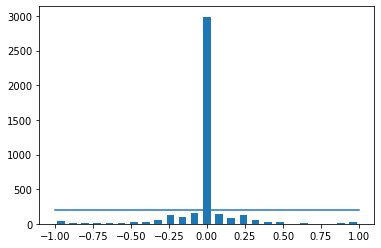

In [27]:
#visualizing the data to check the most frequent steering angle and to make our data ready.
num_bins = 25 #this is the number of interval in which the data is distributed
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5 #making the centre of our steering angle to zero , multiplying so as to get the data in range
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin)) #creating a threshold so that our model is not biased to move straight only


total data: 4053
removed: 2790
remaining: 1263


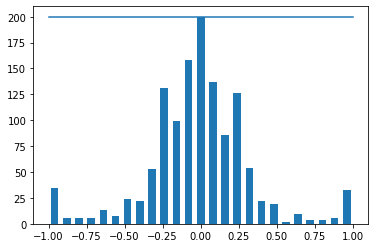

In [28]:
#flatening our data, and also removing all the extraneous bins whose frequency exceeds 1000
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]: #if the steering angle falls under the appropriate value then only we are using it
      list_.append(i)
  list_ = shuffle(list_) #since we are removing the data it should not be such that the data is just being removed from a single part of track
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))


hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [29]:
#seperating the training dataset and testing dataset
print(data.iloc[1])
def load_img_steering(datadir, df): #df = data frame data
  image_path = []
  steering = []
  for i in range(len(data)): 
    indexed_data = data.iloc[i] # iloc allows us to perform a selection on row of data from our data frame based on specific index
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) #strip function removes any spaces in the file name string
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
#the output just shows that we have got the data in the desired format.
image_paths, steerings = load_img_steering(datadir + '/IMG', data) #by this we have two arrays one in which we have all the photos that our car took and the coresponding steering angle

center      center_2018_07_16_17_11_44_485.jpg
left        left_2018_07_16_17_11_44_485.jpg  
right       right_2018_07_16_17_11_44_485.jpg 
steering   -0.25                              
throttle    0.863326                          
reverse     0.0                               
speed       2.173052                          
Name: 13, dtype: object


In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1010
Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

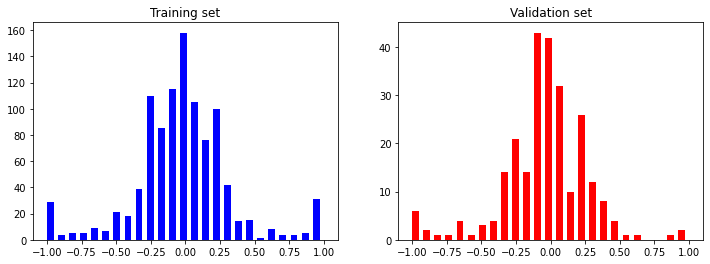

In [31]:
#visualising our training set and validation set to have a better interpretation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [40]:
def img_preprocess(img):
    img = mpimg.imread(img)
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    fig.tight_layout()
    img = img[60:135,:,:] #croping our image to focus on just important parts
    axs[0].imshow(img)
    axs[0].set_title('After Crop')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0) #smoothing the image and reduce the noise
    axs[1].imshow(img)
    axs[1].set_title('After Gaussian Blur')
    img = cv2.resize(img, (200, 66)) #reducing the size for better computation and to fit the nvidia model
    img = img/255 #normalising the image
    return img

Text(0.5, 1.0, 'Preprocessed Image')

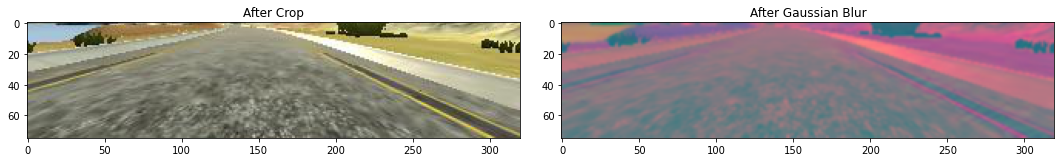

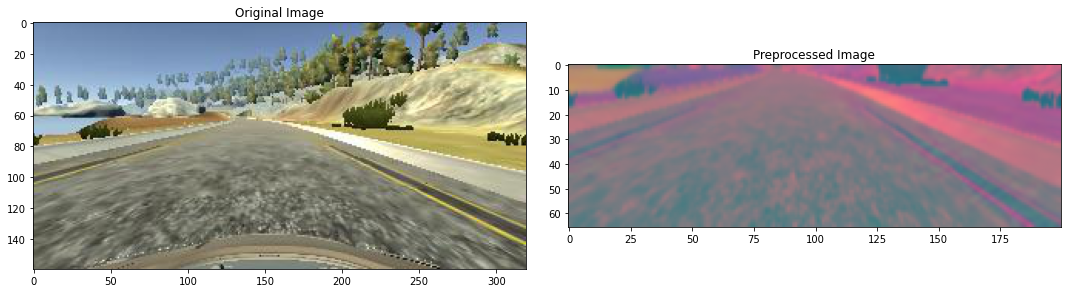

In [41]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image =img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [34]:
X_train = np.array(list(map(img_preprocess,X_train)))
X_valid = np.array(list(map(img_preprocess,X_valid)))

In [35]:
def nvidia_model():
  model = Sequential() #our kernel will move two pixels at a time strides (2,2)
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66,200,3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))

  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1)) #output node
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss = 'mse',optimizer=optimizer)
  return model

In [36]:
model = nvidia_model()
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [37]:
history = model.fit(X_train, y_train,epochs=30,validation_data=(X_valid, y_valid),batch_size=100,verbose=1,shuffle = 1)

Epoch 1/30
11/11 [==============================] - 13s 77ms/step - loss: 0.8877 - val_loss: 0.2287
Epoch 2/30
11/11 [==============================] - 0s 23ms/step - loss: 0.3013 - val_loss: 0.1146
Epoch 3/30
11/11 [==============================] - 0s 23ms/step - loss: 0.1731 - val_loss: 0.0934
Epoch 4/30
11/11 [==============================] - 0s 23ms/step - loss: 0.1324 - val_loss: 0.0894
Epoch 5/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1347 - val_loss: 0.0883
Epoch 6/30
11/11 [==============================] - 0s 22ms/step - loss: 0.1473 - val_loss: 0.0842
Epoch 7/30
11/11 [==============================] - 0s 22ms/step - loss: 0.1310 - val_loss: 0.0827
Epoch 8/30
11/11 [==============================] - 0s 23ms/step - loss: 0.1233 - val_loss: 0.0775
Epoch 9/30
11/11 [==============================] - 0s 22ms/step - loss: 0.1174 - val_loss: 0.0747
Epoch 10/30
11/11 [==============================] - 0s 22ms/step - loss: 0.1127 - val_loss: 0.0680
Epoch 11

Text(0.5, 0, 'Epoch')

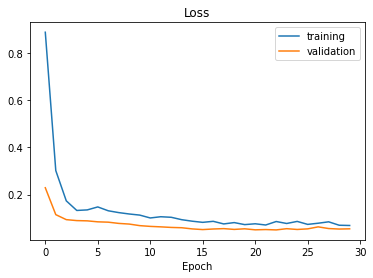

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [39]:
model.save('model.h5')

In [194]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>